# Analysis of Effects from Artilces of Posts

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import kruskal
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
#set format to float with 4 decimals
pd.set_option('display.float_format', '{:.4f}'.format)

Load, specify and visualize data for analysis

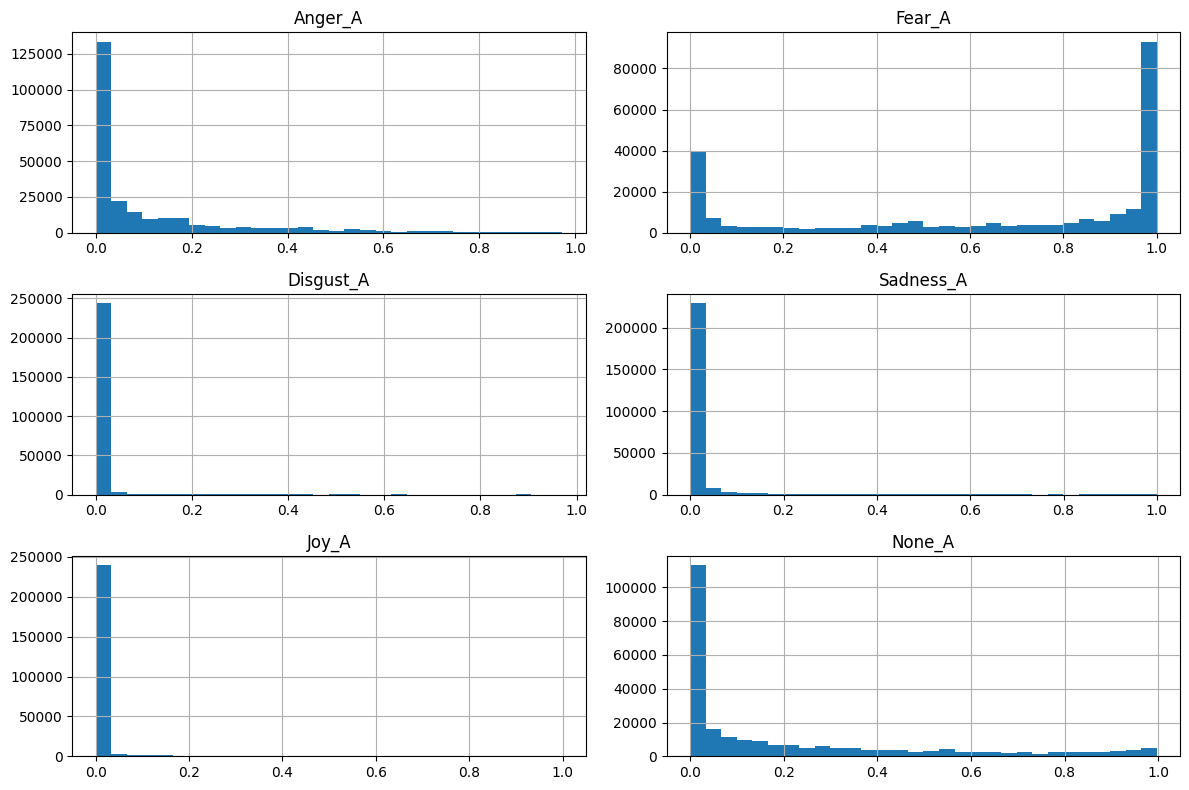

In [3]:
#read data
sentiments = pd.read_csv("sentiment_results.csv")

#emotions of articles(_A) and posts(_P) included in the analysis 
emotions_a = ['Anger_A', 'Fear_A', 'Disgust_A', 'Sadness_A', 'Joy_A', 'None_A']
emotions_p = ['Anger_P', 'Fear_P', 'Disgust_P', 'Sadness_P', 'Joy_P', 'None_P']

#filter relevant colums
sentiments = sentiments[emotions_a + ['NewsroomTopic'] + emotions_p]

#visualize distribution of predictors
sentiments[emotions_a].hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

Set Global Parameters

In [4]:
#set for optimal cpu utilisation
parallel_jobs = 10

#settings to account for testing errors
alpha = 0.05
bootstrap_samples = 2000

#ranking parameters for emotions in articles
between_ranks = 2
rank_threshold = 1/6
min_rank_size = 20

#set seed for reproducibility
seed = 666

Precompute Variables

In [5]:
#prepare topics
sentiments['NewsroomTopic'] = sentiments['NewsroomTopic'].astype('category')
topics = sentiments['NewsroomTopic'].to_numpy()
topic_levels = sentiments['NewsroomTopic'].cat.categories.to_numpy()

#convert DV arrays for faster access
dv_arrays = {dv: sentiments[dv].to_numpy() for dv in emotions_p}

#generate seed based bootstrap indices for tests
rng = np.random.default_rng(seed)
n = len(sentiments)

bootstrap_indices = []
for i in range(bootstrap_samples):
    idx = rng.choice(n, size=n, replace=True)
    bootstrap_indices.append(idx)

#build dicts to store bootstrap stats
boot_pvalues_dict = {}
boot_epsilon_dict = {}
boot_k_dict = {}
boot_desc_means_dict = {}

#bonferroni correction of alpha value
alpha_corrected = alpha / (len(emotions_a) * len(emotions_p) + len(emotions_p))

Test Functions

In [6]:
def kruskal_test(groups):

    clean_groups = [g for g in groups if len(g) > 0]

    if len(clean_groups) <= 1:
        return np.nan, np.nan, np.nan, np.nan
    
    H, p = kruskal(*clean_groups)
    k = len(clean_groups)
    n_total = sum(len(g) for g in clean_groups)
    epsilon = (H - k + 1) / (n_total - k) if n_total > k else np.nan

    return H, p, epsilon, k

In [7]:
def bootstrap_stats(H_list, epsilon_list, p_list, k_list):
    
    H_arr = np.array(H_list)
    eps_arr = np.array(epsilon_list)
    p_arr = np.array(p_list)
    k_arr = np.array(k_list)
    
    return {
        "H_mean": np.nanmean(H_arr),
        "epsilon2_mean": np.nanmean(eps_arr),
        "epsilon2_ci_lower": np.nanpercentile(eps_arr, 100 * alpha / 2),
        "epsilon2_ci_upper": np.nanpercentile(eps_arr, 100 * (1 - alpha / 2)),
        "mean_p_value": np.nanmean(p_arr),
        "signif_prob": np.mean(p_arr <= alpha_corrected) if len(p_arr) > 0 else np.nan,
        "mean_k": np.nanmean(k_arr)
    }

Analysis of Emotions

In [8]:
def emotion_bootstrap(idx_list, dv, iv_emo):

    H_vals, epsilon_vals, p_vals, k_vals = [], [], [], []
    for idx in idx_list:
        dv_data = dv_arrays[dv][idx]
        iv_data = sentiments[iv_emo].to_numpy()[idx]

        if rank_threshold > 0:
            low = rank_threshold
            high = 1 - rank_threshold
            middle_edges = np.linspace(low, high, between_ranks + 1)
            edges = np.concatenate([[0], middle_edges, [1]])
        else:
            edges = np.linspace(0, 1, between_ranks + 1)

        edges = np.unique(edges)

        rank_data = pd.cut(
            iv_data,
            bins=edges,
            labels=False,
            include_lowest=True,
            duplicates='drop'
        ) + 1

        ranks = [dv_data[rank_data == r] for r in range(1, len(edges))]

        valid_ranks = [r for r in ranks if len(r) >= min_rank_size]

        if len(valid_ranks) < 2:
            continue

        H, p, epsilon, k = kruskal_test(valid_ranks)

        if not np.isnan(H):
            H_vals.append(H)
            epsilon_vals.append(epsilon)
            p_vals.append(p)
            k_vals.append(k)

    return {"H": H_vals, "epsilon": epsilon_vals, "p": p_vals, "k": k_vals}

In [9]:
def emotion_parallel(dv, iv_emo):
    
    split_indices = np.array_split(bootstrap_indices, parallel_jobs)
    results = Parallel(n_jobs=parallel_jobs)(
        delayed(emotion_bootstrap)(sub_idx, dv, iv_emo) for sub_idx in split_indices)

    H_all, eps_all, p_all, k_all = [], [], [], []
    for r in results:
        H_all.extend(r["H"])
        eps_all.extend(r["epsilon"])
        p_all.extend(r["p"])
        k_all.extend(r["k"])

    boot_epsilon_dict[(dv, iv_emo)] = eps_all
    boot_pvalues_dict[(dv, iv_emo)] = p_all
    boot_k_dict[(dv, iv_emo)] = k_all

    return bootstrap_stats(H_all, eps_all, p_all, k_all)

Analysis of Topics

In [10]:
def topic_bootstrap(idx_list, dv):

    H_vals, epsilon_vals, p_vals, k_vals = [], [], [], []
    for idx in idx_list:
        dv_data = dv_arrays[dv][idx]
        topic_data = topics[idx]
        groups = [dv_data[topic_data == lvl] for lvl in topic_levels]
        H, p, epsilon, k = kruskal_test(groups)
        
        if not np.isnan(H):
            H_vals.append(H)
            epsilon_vals.append(epsilon)
            p_vals.append(p)
            k_vals.append(k)

    return {"H": H_vals, "epsilon": epsilon_vals, "p": p_vals, "k": k_vals}

In [11]:
def topic_parallel(dv):
    
    split_indices = np.array_split(bootstrap_indices, parallel_jobs)
    results = Parallel(n_jobs=parallel_jobs)(
        delayed(topic_bootstrap)(sub_idx, dv) for sub_idx in split_indices)

    H_all, eps_all, p_all, k_all = [], [], [], []
    for r in results:
        H_all.extend(r["H"])
        eps_all.extend(r["epsilon"])
        p_all.extend(r["p"])
        k_all.extend(r["k"])

    boot_epsilon_dict[(dv, "NewsroomTopic")] = eps_all
    boot_pvalues_dict[(dv, "NewsroomTopic")] = p_all
    boot_k_dict[(dv, "NewsroomTopic")] = k_all

    return bootstrap_stats(H_all, eps_all, p_all, k_all)

Descriptive statistics

In [12]:
def descriptive_stats():

    numeric_vars = emotions_a + emotions_p
    topics_arr = sentiments["NewsroomTopic"].to_numpy()

    rows = []
    for var in numeric_vars:
        x = sentiments[var].to_numpy()

        for lvl in topic_levels:
            topic_mask = topics_arr == lvl
            data = x[topic_mask]

            if data.size == 0:
                continue

            mean = np.mean(data)
            std = np.std(data, ddof=1)
            boot_means = np.empty(bootstrap_samples)

            for b in range(bootstrap_samples):
                sample_idx = bootstrap_indices[b]
                sample_data = x[sample_idx][topic_mask[sample_idx]]
                boot_means[b] = (
                    np.mean(sample_data) if sample_data.size > 0 else np.nan
                )

            mean_ci_lower = np.nanpercentile(boot_means, 100 * alpha / 2)
            mean_ci_upper = np.nanpercentile(boot_means, 100 * (1 - alpha / 2))
            boot_desc_means_dict[(var, lvl)] = boot_means
            rows.append({
                "variable": var,
                "topic": lvl,
                "mean": mean,
                "mean_ci_lower": mean_ci_lower,
                "mean_ci_upper": mean_ci_upper,
                "std": std
            })

    return pd.DataFrame(rows)

In [13]:
def bootstrap_distributions():

    records = []

    for (criterion, predictor), values in boot_pvalues_dict.items():
        for v in values:
            records.append({
                "stat_type": "p",
                "criterion": criterion,
                "predictor": predictor,
                "variable": None,
                "topic": None,
                "value": v
            })

    for (criterion, predictor), values in boot_epsilon_dict.items():
        for v in values:
            records.append({
                "stat_type": "epsilon",
                "criterion": criterion,
                "predictor": predictor,
                "variable": None,
                "topic": None,
                "value": v
            })

    for (criterion, predictor), values in boot_k_dict.items():
        for v in values:
            records.append({
                "stat_type": "k",
                "criterion": criterion,
                "predictor": predictor,
                "variable": None,
                "topic": None,
                "value": v
            })

    for (variable, topic), values in boot_desc_means_dict.items():
        for v in values:
            records.append({
                "stat_type": "mean",
                "criterion": None,
                "predictor": None,
                "variable": variable,
                "topic": topic,
                "value": v
            })

    df = pd.DataFrame.from_records(records)
    return df

Summarize Testings with Structured Output

In [14]:
def kruskal_wallis_bootstrap():

    test_rows = []
    for dv in emotions_p:

        for iv_emo in emotions_a:
            stats = emotion_parallel(dv, iv_emo)
            signif_label = "yes" if stats["epsilon2_ci_lower"] > 0 else "no"
            test_rows.append({
                "criterion": dv,
                "predictor": iv_emo,
                "type": "emotion",
                "signif_label": signif_label,
                **stats
            })

        stats = topic_parallel(dv)
        signif_label = "yes" if stats["epsilon2_ci_lower"] > 0 else "no"
        test_rows.append({
            "criterion": dv,
            "predictor": "NewsroomTopic",
            "type": "NewsroomTopic",
            "signif_label": signif_label,
            **stats
        })

    test_df = pd.DataFrame(test_rows)
    desc_df = descriptive_stats()
    boot_df = bootstrap_distributions()

    return test_df, desc_df, boot_df

# Run Analysis

In [15]:
test_stats, desc_stats, boot_stats = kruskal_wallis_bootstrap()

Save test_stats as CSV

In [16]:
test_stats.to_csv('test_stats.csv', index=False)

In [17]:
desc_stats.to_csv('descriptive_stats.csv', index=False)

In [18]:
boot_stats.to_csv('bootstrap_stats.csv', index=False)